In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge,Lasso,RidgeCV,LassoCV,ElasticNet,ElasticNetCV,LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import pickle
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        


In [2]:
df=pickle.load(open('Power_consumption.pkl','rb'))
df=df.drop(columns=['quarter','month','day'])
dfs=df.sample(n=5000)

## Lets check the correlation

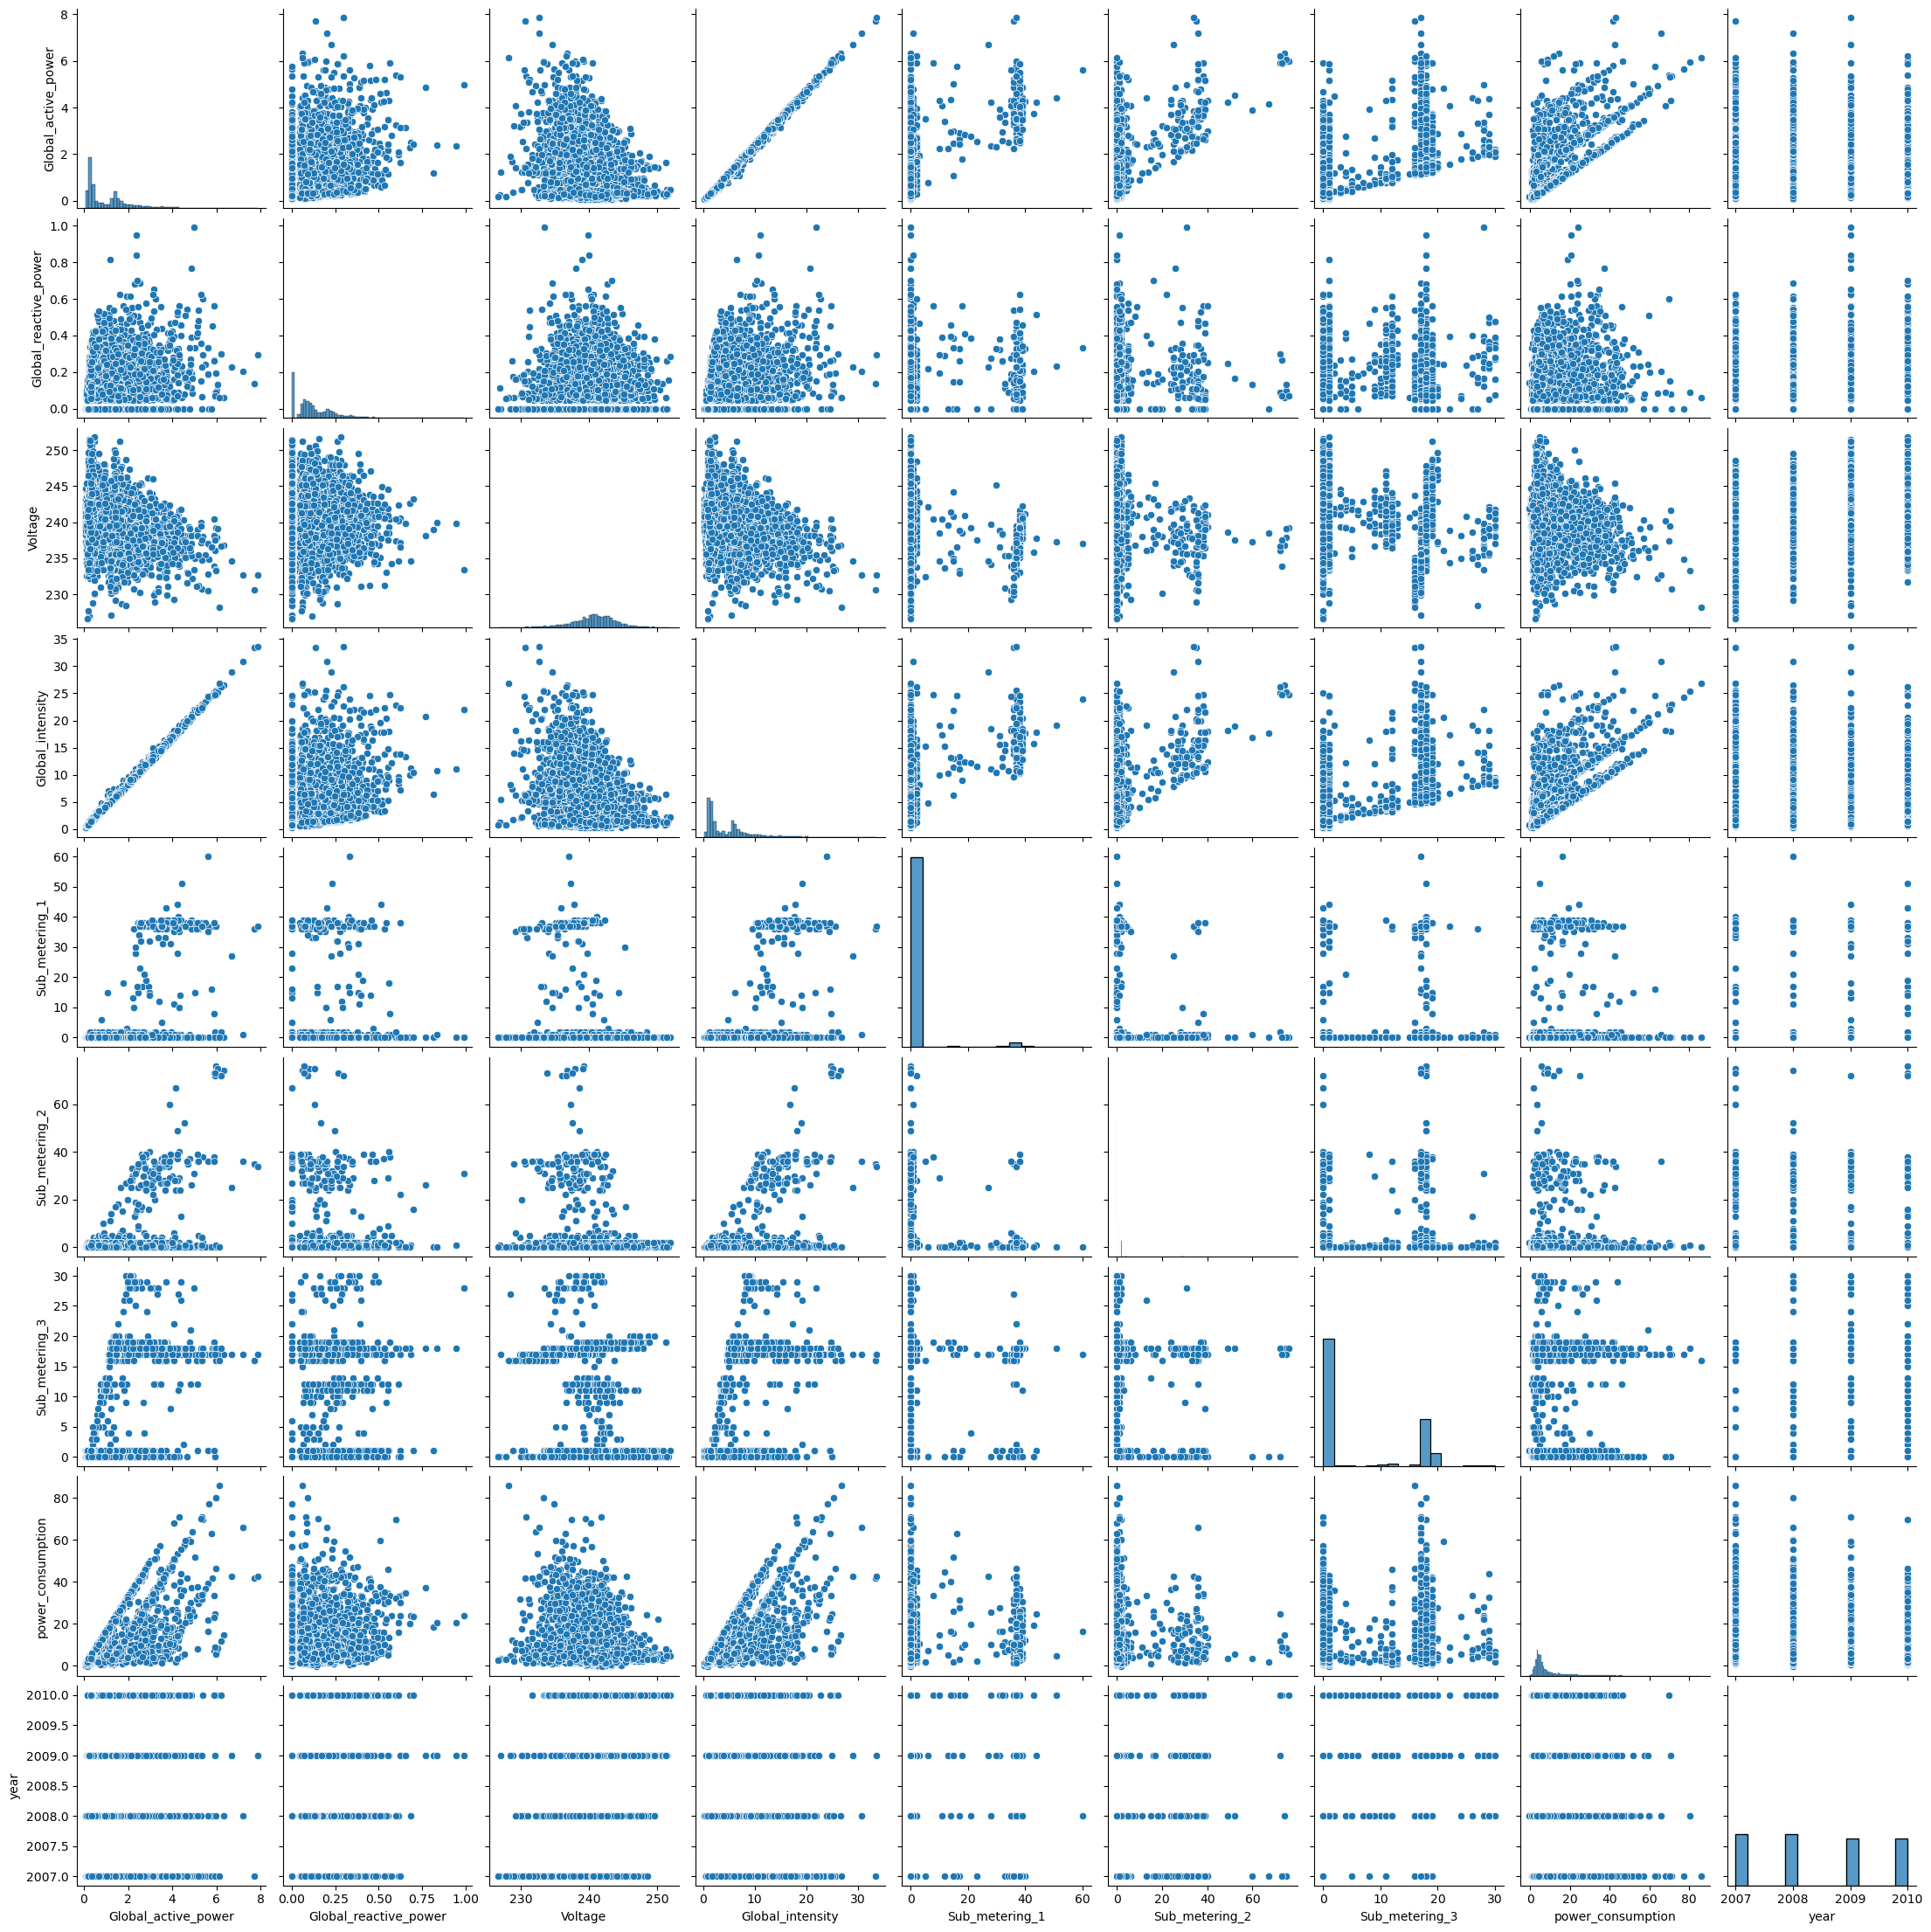

In [3]:
sns.pairplot(dfs)

<AxesSubplot:>

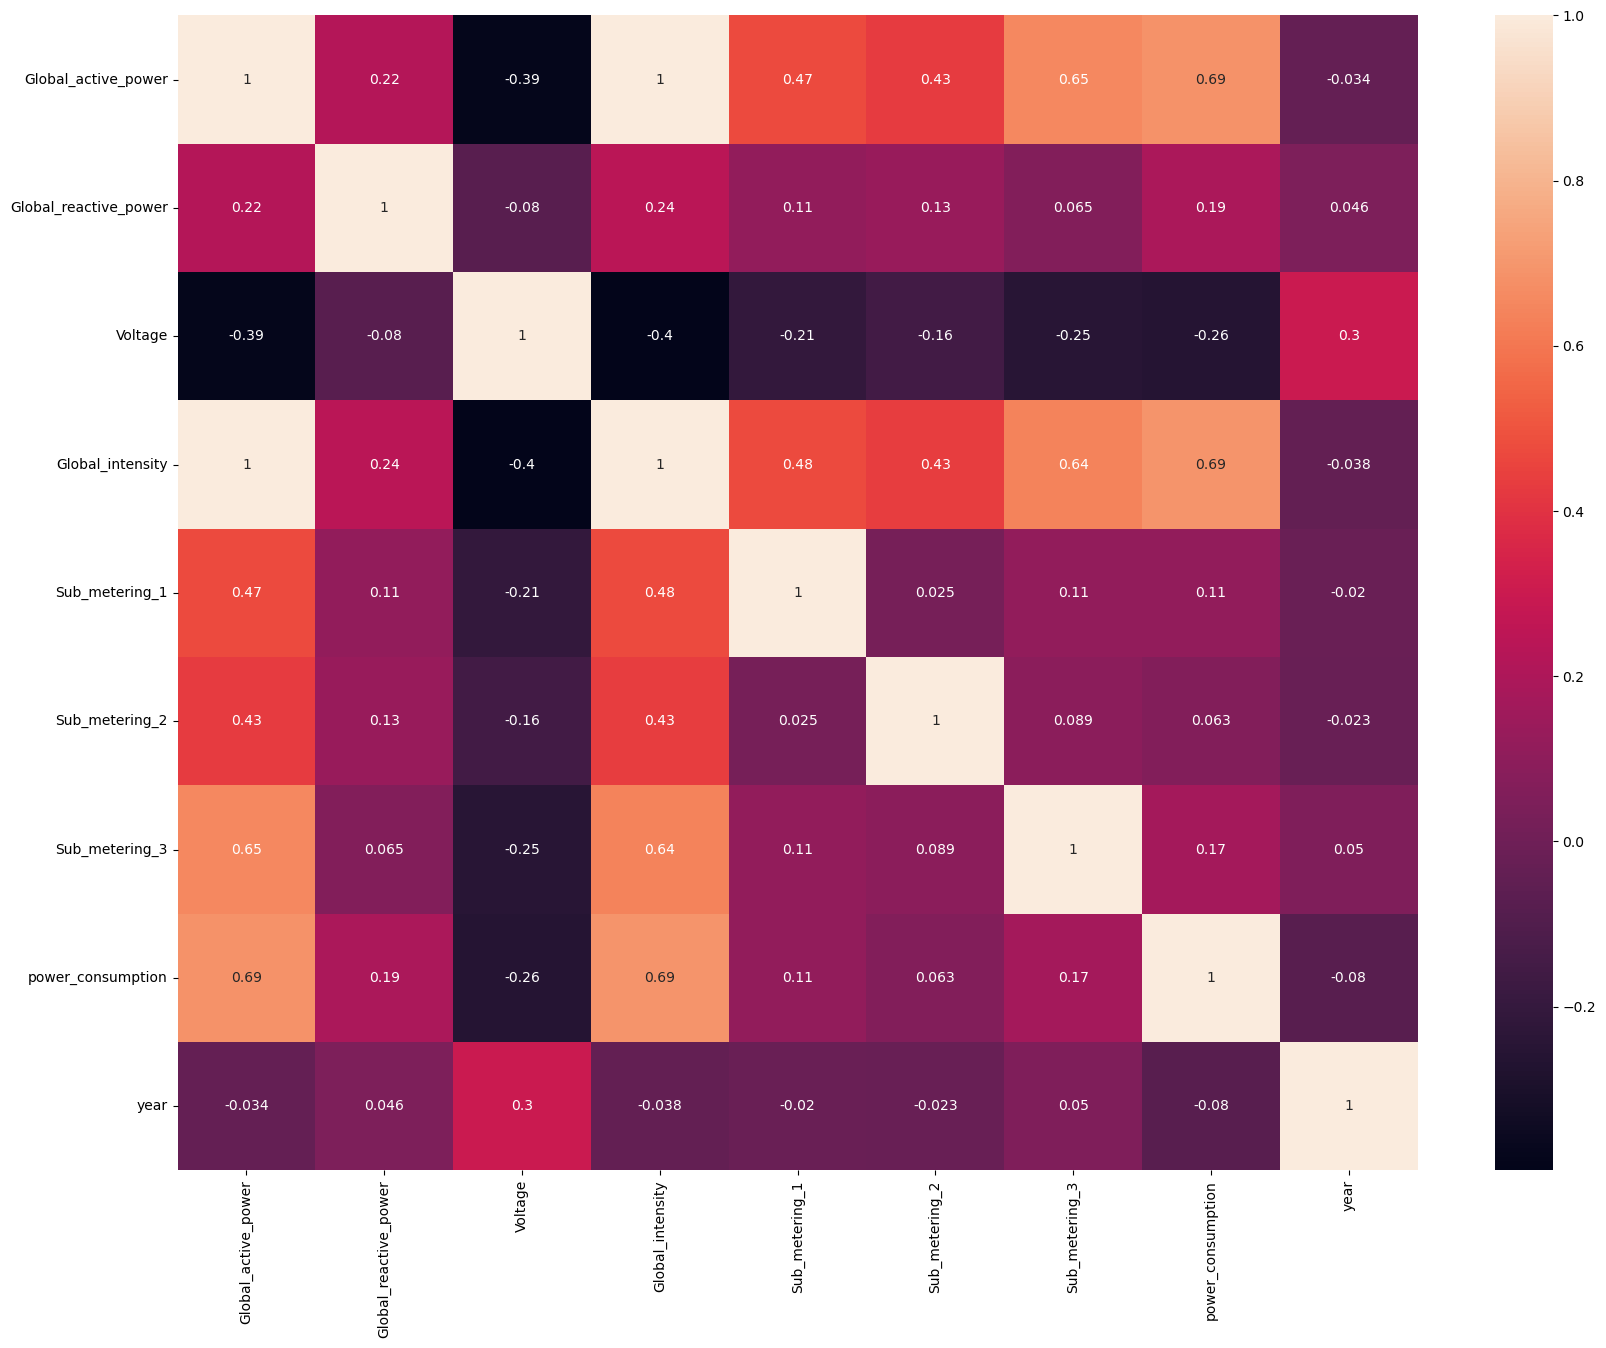

In [4]:
plt.figure(figsize=(20,15))
sns.heatmap(dfs.corr(),annot=True)


### Observation
1. In the pairplot and heatmap we see alot of variables are dependent on each other such as GlobalActive Power and Voltage , Global intensity and voltage, Power consumption and voltage .
2. The parameters have high multicolinierity

In [5]:
import statsmodels.api as sm
X = np.column_stack((dfs[['Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3']], np.ones(len(dfs[['Global_active_power']]))))

# fit the multiple linear regression model
y=dfs[['power_consumption']]
model = sm.OLS(y, X).fit()

# print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      power_consumption   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.300e+31
Date:                Sun, 30 Apr 2023   Prob (F-statistic):               0.00
Time:                        16:46:02   Log-Likelihood:             1.4737e+05
No. Observations:                5000   AIC:                        -2.947e+05
Df Residuals:                    4992   BIC:                        -2.947e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            16.6667   1.43e-14   1.17e+15      0.0

### Observation
We add a column of ones to the input data to represent the intercept term and then use the OLS function from statsmodels to fit the multiple linear regression model. Finally, we print the model summary to view the regression coefficients, p-values, and other statistics.

#### Insights
statsmodels.api is a Python library that provides classes and functions for the estimation of statistical models, conducting statistical tests, and exploring data.

The library offers a wide range of statistical methods for data analysis and modeling, including regression analysis, time series analysis, survival analysis, and generalized linear models, among others. It provides a user-friendly interface for fitting statistical models, generating model diagnostics, and making predictions.

## Seperating the Independant and Dependant Features

In [40]:
#We drop few columns before scaling to avoid multicollinearity 
X=dfs.drop(columns=['date_time','date','power_consumption','Date','Time','Global_active_power'])
y=dfs['power_consumption']

## Data Splitting

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

## Standardization of  the datasets

In [42]:
#We re-fit our model on the original, non-standardized data.
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

## We check for multicollinearity

In [43]:
vif=pd.DataFrame()
vif['Factor']=[variance_inflation_factor(X_test,i) for i in range(X_test.shape[1])]
vif['Features']=X.columns
vif

,Factor,Features
0,1.090218,Global_reactive_power
1,1.338192,Voltage
2,4.074650,Global_intensity
3,1.683906,Sub_metering_1
4,1.564230,Sub_metering_2
5,2.150379,Sub_metering_3
6,1.119577,year


### Observation
1. We removed the Global_active_power column to avoid multicollinearity as it was highly corelated to Global_intensity and making it difficult to determine the effect of each variable on the dependent variable.
2. VIF is a measure of how much the variance of the estimated regression coefficient is increased due to multicollinearity.
3. We Split and Standardised the model first before checking for the VIF ,this ensures that the same scaling is applied to both the training and testing data. 
4. We checked for multicollinearity on the training dataset

## Model Training

In [44]:
regression=LinearRegression()
regression.fit(X_train,y_train)

LinearRegression()

In [45]:
#Printing the co efficients and intercepts
print('co efficients-',regression.coef_)
print(' ')
print('**************************************************************************')
print('Intercepts-',regression.intercept_)

co efficients- [-3.38088393e-01  2.23494746e-01  1.70421978e+01 -5.91567046e+00
 -5.93302314e+00 -8.09500317e+00  7.94391540e-03]
 
**************************************************************************
Intercepts- 9.217880597014924


#### Prediction for the test data

In [46]:
reg_pred=regression.predict(X_test)
reg_pred

array([6.76165885, 5.4535126 , 2.96268503, ..., 4.50198506, 6.7183467 ,
       1.39848656])

#### Assumtions of linear regression (almost 3 assumtions are taken)

Text(0, 0.5, 'Test Predicted data')

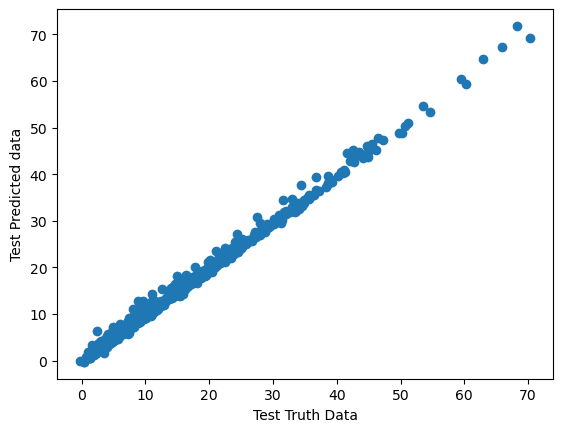

In [47]:
# 1st Assumtion
plt.scatter(y_test,reg_pred)
plt.xlabel('Test Truth Data')
plt.ylabel('Test Predicted data')


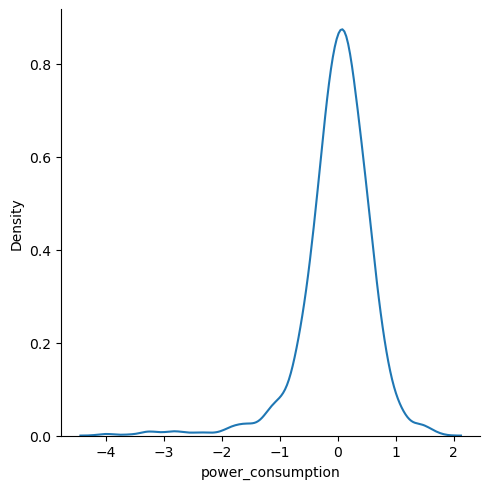

In [48]:
#2nd Assumption residual
residual=y_test-reg_pred
residual
sns.displot(residual,kind='kde') #residual plot should always be a normal distribution 

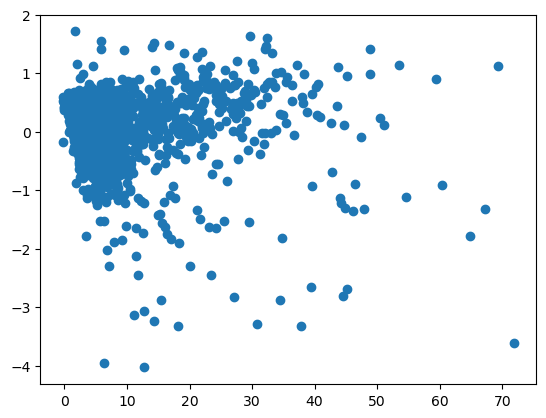

In [49]:
#3rd .Scatter plot with prediction and residual
# It should be a uniform distribution should not have any kind of shape
plt.scatter(reg_pred,residual) 

### Performance Matrix

In [50]:
print(mean_squared_error(y_test,reg_pred))
print(mean_absolute_error(y_test,reg_pred))
print(np.sqrt(mean_squared_error(y_test,reg_pred)))

0.36247331284177714
0.4128085614514408
0.6020575660530952


### Observation
1. The MSE value of 0.36247331284177714 means that, on average, the squared difference between the predicted and actual values is 0.4128085614514408. A lower MSE indicates better performance, as it means that the predicted values are closer to the actual values.
2. A lower MAE value indicates better performance, as it means that the predicted values are closer to the actual values. The MAE is also easier to interpret than the MSE since it is measured in the same units as the original data. In general, the MAE is useful when you want to know the typical size of the errors in your predictions, and it is less sensitive to outliers than the MSE.

####  R square and adjusted r-square

In [51]:
score=r2_score(y_test,reg_pred)
print(score)

0.9958453783523954


In [52]:
1-(1-score)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

0.9958276668106577

### Observation
1. A high R-squared value, such as 0.9953319633300511, indicates that the regression model is a good fit for the data and is able to capture the underlying relationships between the independent and dependent variables. In practical terms, this means that the model can accurately predict the dependent variable based on the independent variable(s) with a high degree of confidence.

## Regularization

### Ridge Regression

In [53]:
#Train the model
rid = Ridge(alpha=1.0)
rid.fit(X_train, y_train)


Ridge()

In [54]:
# Predict on the testing set
x_test_pred_rd = rid.predict(X_test)
r2_score(y_test, x_test_pred_rd)
print(mean_squared_error(y_test,x_test_pred_rd))
print(mean_absolute_error(y_test,x_test_pred_rd))
print(np.sqrt(mean_squared_error(y_test,x_test_pred_rd)))

0.3631581761655317
0.41388071949919225
0.6026260666163817


### Lasso Regression

In [55]:
#Train the model
las=Lasso()
las.fit(X_train, y_train)


Lasso()

In [62]:
# Predict on the testing set
y_predl = las.predict(X_test)
print(r2_score(y_test, y_predl))
print(mean_squared_error(y_test,y_predl))
print(mean_absolute_error(y_test,y_predl))
print(np.sqrt(mean_squared_error(y_test,y_predl)))

0.7678749842197049
20.251934014700126
2.901499673775687
4.5002148853916


### ElasticnetCv

In [57]:
# Create the ElasticNetCV object with a range of alpha and l1_ratio values
elastic_net_cv = ElasticNetCV(alphas=[0.1, 1.0, 10.0], l1_ratio=[0.25, 0.5, 0.75])

# Train the model on the training set using cross-validation
elastic_net_cv.fit(X_train, y_train)

# Predict on the testing set
y_pred = elastic_net_cv.predict(X_test)

# Evaluate the model using mean squared error and r2 score
r2 = r2_score(y_test, y_pred)
print("R2 score on test set:", r2)
print(mean_squared_error(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
print(np.sqrt(mean_squared_error(y_test,y_pred)))

# Print the optimal value of alpha and l1_ratio that gives the best score
print("Optimal value of alpha:", elastic_net_cv.alpha_)
print("Optimal value of l1_ratio:", elastic_net_cv.l1_ratio_)
print()

R2 score on test set: 0.9732908472847474
2.330261547035567
1.0190048563191743
1.5265194224233005
Optimal value of alpha: 0.1
Optimal value of l1_ratio: 0.75



#### Fine tuning the model on alpha and l1 and retraining the model on the full training dataset

In [58]:
alpha = 0.1
l1_ratio = 0.75

# Train the model on the full training dataset
model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
model.fit(X_train, y_train)

# Evaluate the model on the test dataset
y_pred = model.predict(X_test)
print(mean_squared_error(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
print(np.sqrt(mean_squared_error(y_test,y_pred)))

2.330261547035567
1.0190048563191743
1.5265194224233005


In [59]:
data = [['Linear',0.9949088893854184], ['Lasso',0.7382240914819043], ['Ridge',0.9949088888837155],]
summary = pd.DataFrame(data, columns=['Model', 'R2 Score'])
summary

,Model,R2 Score
0,Linear,0.994909
1,Lasso,0.738224
2,Ridge,0.994909


### Support Vector Regression

In [64]:
# Train SVM regression model
svm_model = SVR()

svm_model = SVR(kernel='linear')
svm_model.fit(X_train, y_train)

# Evaluate model on test set
y_pred = svm_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error on test set: ", mse)

# Calculate the R-squared score
r2 = r2_score(y_test, y_pred)
print("R-squared score:", r2)
print(mean_squared_error(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
print(np.sqrt(mean_squared_error(y_test,y_pred)))

Mean squared error on test set:  0.37858784310530824
R-squared score: 0.9956606757166373
0.37858784310530824
0.4033035165633923
0.6152949236791315


## Summary


In [63]:
data = [['Linear',0.9949088893854184,0.36247331284177714,0.4128085614514408], ['Lasso',0.7382240914819043,20.251934014700126,2.901499673775687],
        ['Ridge',0.9949088888837155,0.3631581761655317,41388071949919225],
        ['ElasticnetCV',0.9732908472847474,2.330261547035567,
            1.0190048563191743],['SVM',0.9956606757166373,0.37858784310530824,
                    0.4033035165633923]]
summary = pd.DataFrame(data, columns=['Model', 'R2 Score','MSE','MAE'])
summary

,Model,R2 Score,MSE,MAE
0,Linear,0.994909,0.362473,4.128086e-01
1,Lasso,0.738224,20.251934,2.901500e+00
2,Ridge,0.994909,0.363158,4.138807e+16
3,ElasticnetCV,0.973291,2.330262,1.019005e+00
4,SVM,0.995661,0.378588,4.033035e-01


# Conclusion

1.  Based on the evaluation metrics R2 score, MSE, and MAE, the best model is the Support Vector Regression (SVM) model with an R2 score of 0.995661, the lowest MSE of 0.378588, and the lowest MAE of 0.403304. The Linear Regression model has a slightly lower MSE and MAE, but the SVM model has a higher R2 score, indicating that it explains more of the variance in the data. The Lasso and ElasticnetCV models have much lower R2 scores and higher MSE and MAE values, indicating that they are less accurate in predicting the target variable. The Ridge Regression model has the same R2 score as the Linear Regression model but has a much higher MAE value, indicating that it is less accurate in predicting the target variable.

2. The evaluation metrics of R2 score, Mean Squared Error (MSE), and Mean Absolute Error (MAE), the linear regression model performed the best among the models of Ridge Regression, Lasso Regression, ElasticNetCV, and SVR. This indicates that the linear regression model was able to explain the maximum amount of variance in the dependent variable using the independent variables and had the least amount of error in its predictions. Therefore, it can be concluded that the linear regression model is the best model for this particular dataset and problem.